# Real and Not Real Tweet







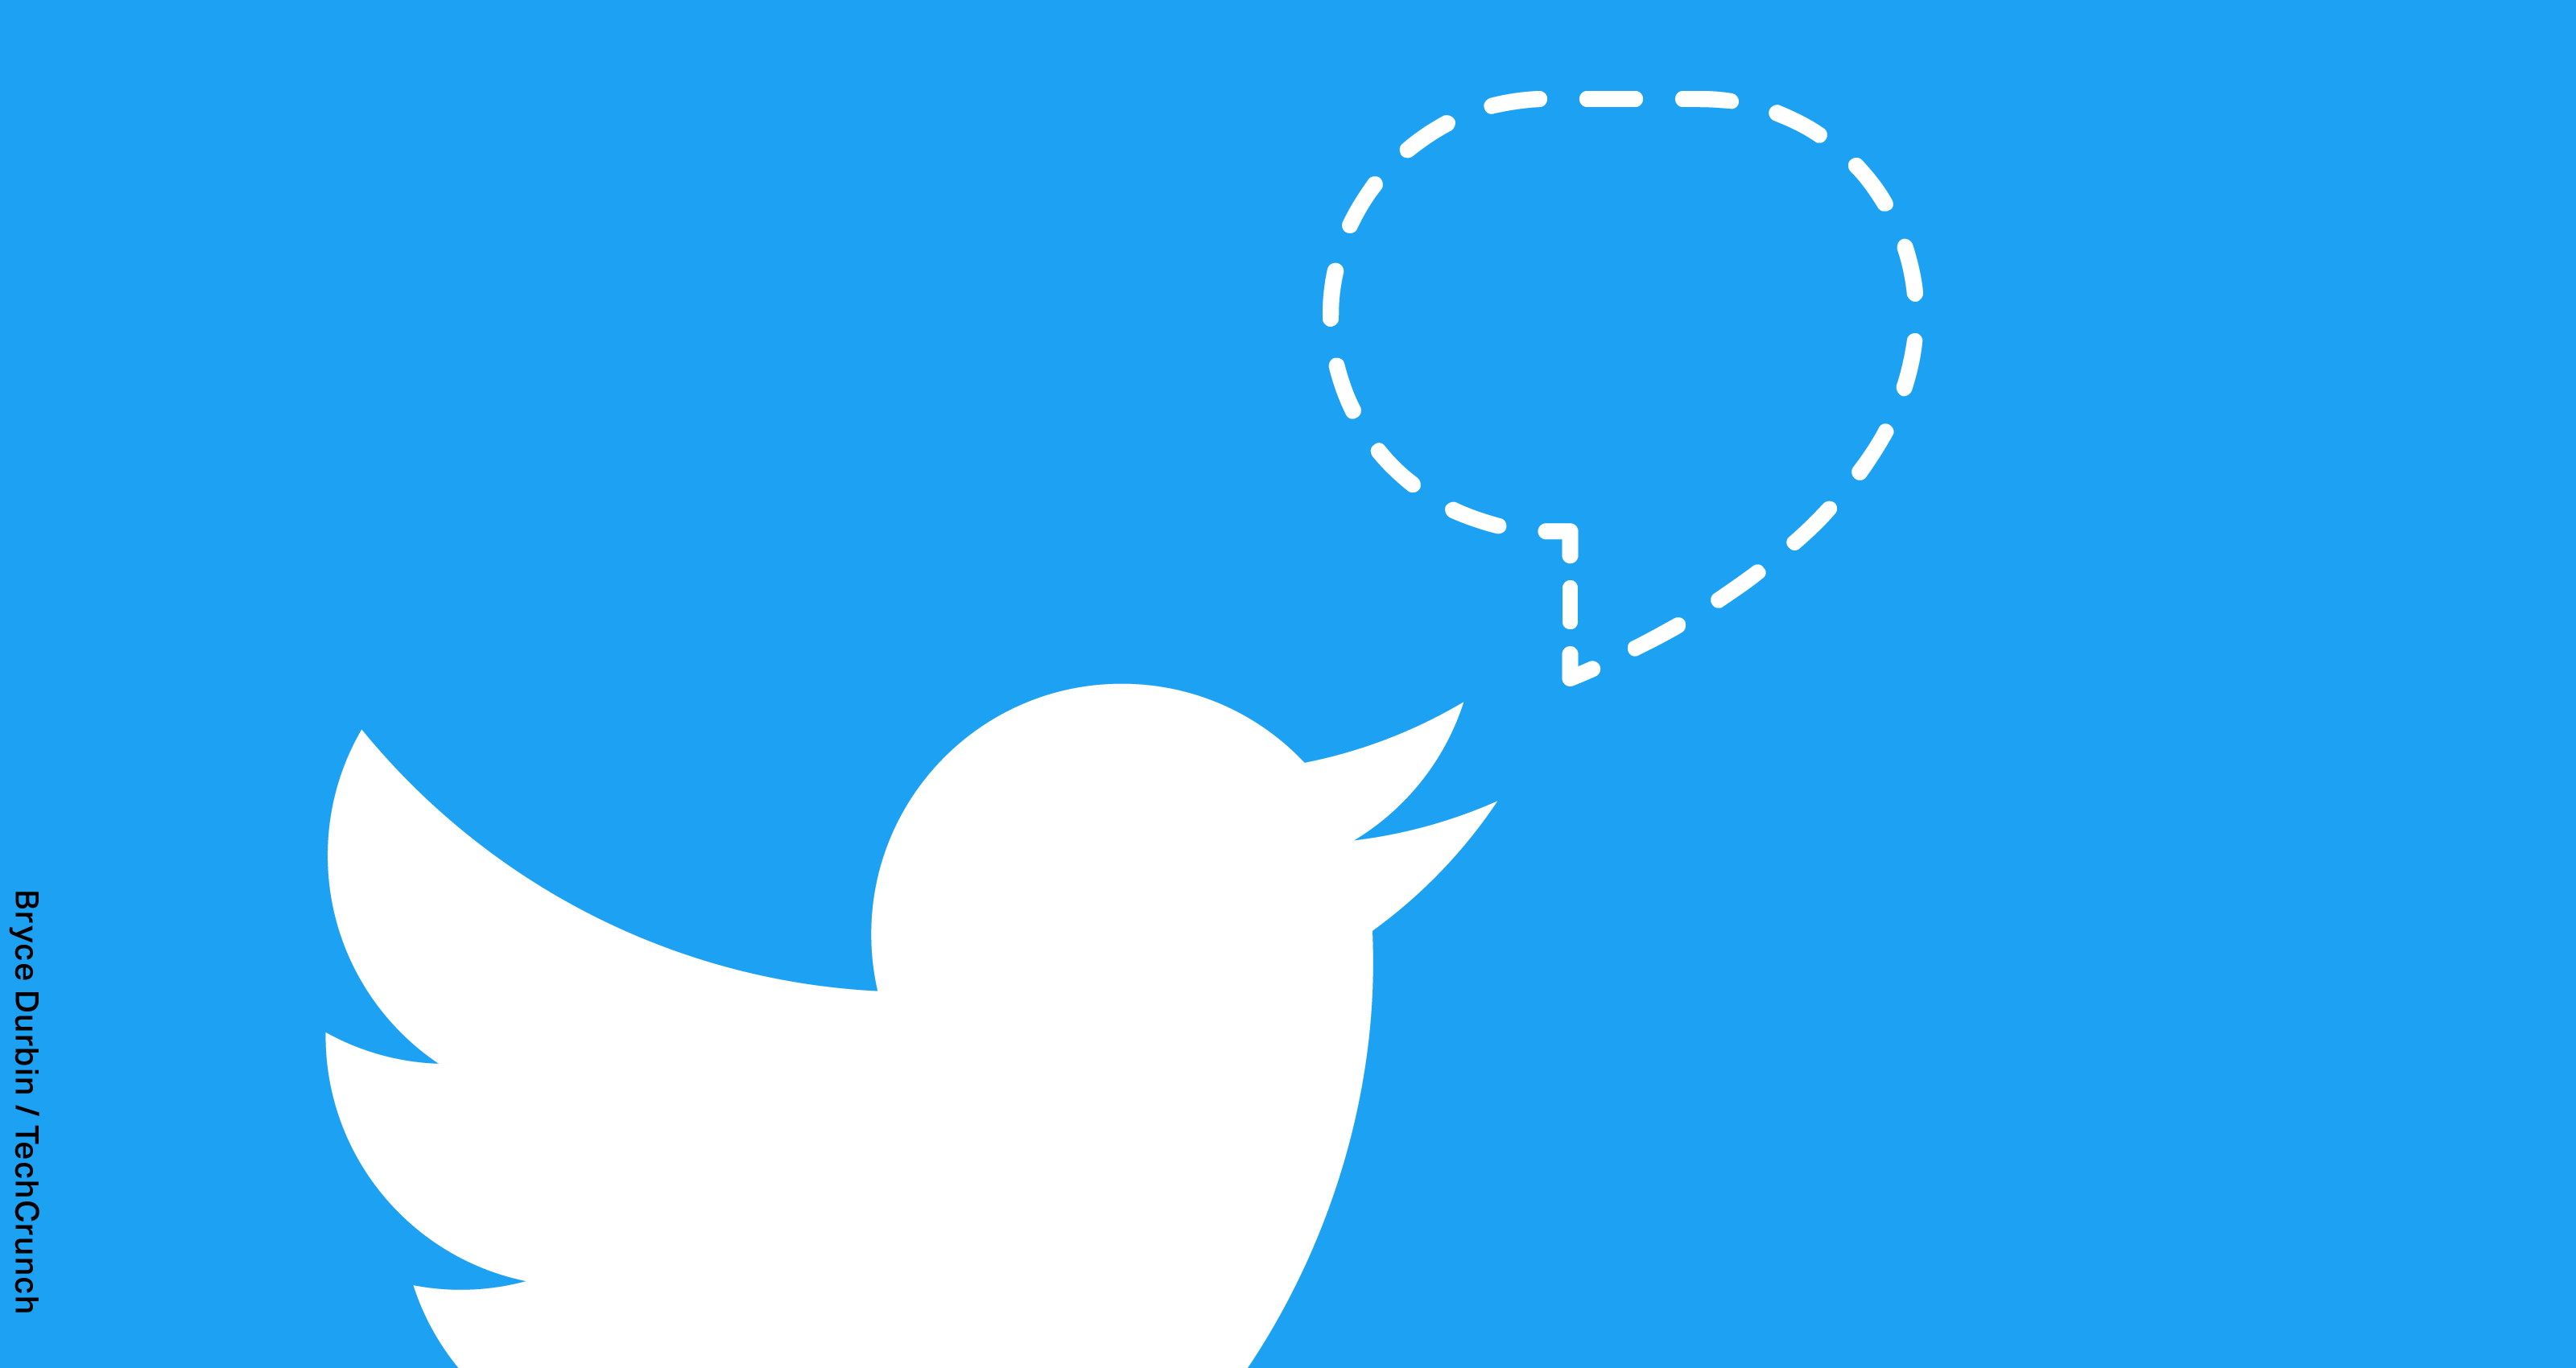

# Table of Contents
* <a id='section1'> References</a>
* <a id='section2'>Introduction </a>
* <a id='Section3'> Basic Understanding of data </a>
* <a id='Section4'> EDA</a>
* <a id='section5'> develope a model using BERT BASE </a>
* <a id='section6'> End Note</a>

## References

FOR MORE INFORMATION

##### For EDA : https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

##### For Modelling : Please Watch this Awesome Video on bert by Mr. Abhishek Thakur
                      https://www.youtube.com/watch?v=hinZO--TEk4&list=PL98nY_tJQXZl0WwsJluhc6tGrKWCX2suH&index=3


## 1. Introduction

**In past year big social networks like Facebook or Twitter admit that on their networks are fake and duplicate accounts, fake
news and fake likes. With these accounts, their creators can distribute false information, support or attack an idea, a product, or an
election candidate, influencing real network users in making a decision. In this notbook, my aim present end to end solution for identifying not real and real Tweets**

# 2. Basic Understanding of Data

## Data and Module

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# For Modelling

from sklearn.metrics import f1_score
import transformers
import torch.nn as nn
from tqdm import tqdm
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AdamW
from sklearn import metrics
from transformers import get_linear_schedule_with_warmup
import numpy as np
import re
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Part A - EDA and Basic Data Analysis

In [ ]:
# Let's Load the data
train = pd.read_csv('../input/nlp-getting-started//train.csv')
test = pd.read_csv(r'../input/nlp-getting-started/test.csv')
train.head()

**As we can see we have lot of null values in data set Let's explore that**

In [ ]:
print("shape of train data is {}".format(train.shape))
print("shape of test data is {}".format(test.shape))

In [ ]:
# checking basic info for test and train
train.info()

In [ ]:
# Data missing information for train
data_info=pd.DataFrame(train.dtypes).T.rename(index={0:'column type'})
data_info=data_info.append(pd.DataFrame(train.isnull().sum()).T.rename(index={0:'null values (nb)'}))
data_info=data_info.append(pd.DataFrame(train.isnull().sum()/train.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(data_info)

In [ ]:
# Data missing information for test
data_info=pd.DataFrame(test.dtypes).T.rename(index={0:'column type'})
data_info=data_info.append(pd.DataFrame(test.isnull().sum()).T.rename(index={0:'null values (nb)'}))
data_info=data_info.append(pd.DataFrame(test.isnull().sum()/test.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(data_info)

* We have Around 80% missing information in keyword feature
* we have 34% missing information in location feature

In [ ]:
# Basic Stats
train.describe()

* Basic statistics always help in many ways. this give the first look about data
* Here we can see we have target mean is .43 which mean we have more non-real tweet compare to real tweet, so let's plot distribtuion

# EDA and Data visualization

In [ ]:
fig = px.bar(train, x=['Not Real','Real'] , y=train['target'].value_counts(),height=400,template="plotly_dark")

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    )
fig.show()

#### Before Doing N-gram Analysis Let's clean the data 

In [ ]:
train.drop(['location','keyword','id'],inplace=True,axis=1)
test.drop(['location','keyword','id'],inplace=True,axis=1)

In [ ]:
def clean_data(data):
    # Lowercaseing 
    data = data.lower()
    
    # Removing alll special char
    data = re.sub(r"[@_!#$%^&*()<>?/\|}{~:-]", ' ', data)
    # Keeping only letters
    data = re.sub(r"[^a-zA-Z.!?']", ' ', data)
    # Removing additional whitespaces
    data = re.sub(r" +", ' ', data)
    
    #Removing all https
    data = re.sub(r'<.*?>',' ',data)
    
    #Removing Emojis
    data = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251""]+",'',data)
    
    #reoving https and https 
    data = data.replace("http",'')
    data = data.replace("https",'')
    data = data.replace("co",'')
    


    return data

In [ ]:
train['text'] = train['text'].apply(lambda x : clean_data(x))
test['text'] = test['text'].apply(lambda x : clean_data(x))

In [ ]:
# Reoving Stop words
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# n-Gram Analysis

### Unigram Words

In [ ]:
def get_top_ngram_words(corpus, n,ngram):
    vec = CountVectorizer((ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_ngram_words(train['text'], 50,1)    
df1 = pd.DataFrame(common_words, columns = ['unigram_words' , 'count'])
fig = px.bar(df1, x= 'unigram_words', y='count',color='count',height=400,template="plotly_dark")
fig.show()

# Bi-gram Words analysis

In [ ]:
common_words = get_top_ngram_words(train['text'], 50,2)    
df1 = pd.DataFrame(common_words, columns = ['bigram_words' , 'count'])
fig = px.bar(df1, x= 'bigram_words', y='count',color='count',height=400,template="plotly_dark")
fig.show()

In [ ]:
def get_top_trigram_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_trigram_words(train['text'], 30)    
df1 = pd.DataFrame(common_words, columns = ['trigram_words' , 'count'])
fig = px.bar(df1, x= 'trigram_words', y='count',color='count',height=400,template="plotly_dark")
fig.show()

### Before Modelling Let's explore the word Cloud also


In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=50, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15,7))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
show_wordcloud(train['text'],"Train set Word Cloud")


## So Let's Jump to modelling

# PART B : BERT BASE UNCASE - PYTORCH 

In [ ]:
# Define Configuration
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 4
EPOCHS = 10
BERT_PATH = "../input/bertbase-uncase/"
MODEL_PATH = "model.bin"
TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH,do_lower_case= True)

In [ ]:
# Model Define
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_PATH)
        self.bert_drop = nn.Dropout(0.2)
        self.out = nn.Linear(768,1)
        #self.outlayer = nn.Linear(10, 1)
    
    def forward(self, ids, mask, token_type_ids):
        _, out2 = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        bert_out= self.bert_drop(out2)        
        #output1  = self.linear1(bert_out)
        output = self.out(bert_out)
        return output

In [ ]:
class BERTDataset:
    def __init__(self,text,target):
        self.text = text
        self.target = target
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        text = str(self.text[item])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.target[item], dtype=torch.float)
        }

In [ ]:
def lossFunction(output,target):
    return nn.BCEWithLogitsLoss()(output,target.view(-1,1))

In [ ]:
def train_fn(data_loader, model, optimizer, device,scheduler):
    model.train()

    for batch, data in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = data["ids"]
        token_type_ids = data["token_type_ids"]
        mask = data["mask"]
        targets = data["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = lossFunction(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
def eval_fn(data_loader, model, device):
    model.eval()
    org_targets = []
    org_outputs = []
    with torch.no_grad():
        for batch, data in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = data["ids"]
            token_type_ids = data["token_type_ids"]
            mask = data["mask"]
            targets = data["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            outputs = torch.sigmoid(outputs)
            org_targets.extend(targets.cpu().detach().numpy().tolist())
            org_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return org_outputs, org_targets

In [ ]:
def compile(data):
    train, valid = train_test_split(data,test_size=0.1,random_state=0,stratify=data.target)

    train_dataset = BERTDataset(
        text=train['text'].values,
        target=train['target'].values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=4
    )

    valid_dataset = BERTDataset(
        text=valid.text.values,
        target=valid.target.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=1
    )

    device = torch.device("cuda")
    model = BERTBaseUncased()
    model.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    train_steps = int(len(train) / TRAIN_BATCH_SIZE *EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=0.00003)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=train_steps
    )

    best_accuracy = 0
    for epoch in range(EPOCHS):
        train_fn(train_data_loader, model, optimizer, device,scheduler)
        outputs, targets = eval_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        accuracy = metrics.accuracy_score(targets, outputs)
        #f1_score = f1_score(targets,outputs,average='macro')
        print(f"Accuracy Score = {accuracy}")
        #print(f"F1 Score is = {f1_score}")
        if accuracy > best_accuracy:
            torch.save(model.state_dict(),MODEL_PATH)
            best_accuracy = accuracy


In [ ]:
if __name__=='__main--':
    compile(train)

## End Note

### Thank you!!! Please Upvote kernel if you like the work